In [125]:
conda install tensorflow

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [3]:
data = pd.read_csv('../data/cpu_memory_usage_v1.csv', header=0)
data

,index,name,tags,time,pod_name,namespace,cpu_usage_nanocores,memory_working_set_bytes
0,1,kubernetes_pod_container,NaN,1.678490e+18,drive-az2-prd-69cbb999bc-wklkm,drive,96624523,1337585664
1,2,kubernetes_pod_container,NaN,1.678490e+18,drive-az2-prd-69cbb999bc-lpr67,drive,89770983,1361653760
2,3,kubernetes_pod_container,NaN,1.678490e+18,drive-az2-prd-69cbb999bc-sgr2x,drive,77112631,1285890048
3,4,kubernetes_pod_container,NaN,1.678490e+18,drive-az2-prd-69cbb999bc-2wdsh,drive,35692946,1254232064
4,5,kubernetes_pod_container,NaN,1.678490e+18,drive-az2-prd-69cbb999bc-chm2j,drive,93409866,1294434304
...,...,...,...,...,...,...,...,...
231630,231631,kubernetes_pod_container,NaN,1.679070e+18,drive-az2-prd-69cbb999bc-wklkm,drive,12293800,1313955840
231631,231632,kubernetes_pod_container,NaN,1.679070e+18,drive-az2-prd-69cbb999bc-sgr2x,drive,9217571,1338773504
231632,231633,kubernetes_pod_container,NaN,1.679070e+18,drive-az2-prd-69cbb999bc-h8hqh,drive,13224852,1415725056
231633,231634,kubernetes_pod_container,NaN,1.679070e+18,drive-az2-prd-69cbb999bc-b8k2z,drive,18092365,1453850624


In [4]:
data['time'] = pd.to_datetime(data['time'], unit='ns')
data = data.loc[data.pod_name == 'drive-az2-prd-69cbb999bc-lpr67']
date_time = pd.to_datetime(data['time'], format='%Y-%M-%D %H:%M:%S')

In [5]:
data = data.loc[:,['cpu_usage_nanocores', 'memory_working_set_bytes']]
X = data.loc[:,['cpu_usage_nanocores']]
Y = data.loc[:,['memory_working_set_bytes']]
X.shape, Y.shape

((19304, 1), (19304, 1))

In [6]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [7]:
data = data.loc[:,['memory_working_set_bytes']]

In [8]:
seq_length = 24
X, Y = create_sequences(data, seq_length)
X.shape, Y.shape

((19280, 24, 1), (19280, 1))

In [9]:
train_size = 15000
offset_size = 1000
X_train, y_train = X[:train_size], Y[:train_size]
X_val, y_val = X[train_size:train_size+offset_size], Y[train_size:train_size+offset_size]
X_test, y_test = X[train_size+offset_size:], Y[train_size+offset_size:]


In [10]:

MIN = X_train.min()
MAX = X_train.max()

In [11]:

def MinMaxScale(array, min, max):

    return (array - min) / (max - min)

In [12]:

#MinMax 스케일링
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

In [14]:
y_train = pd.DataFrame(y_train, columns = ['memory_working_set_bytes'])
y_val = pd.DataFrame(y_val, columns = ['memory_working_set_bytes'])

y_test = pd.DataFrame(y_test, columns = ['memory_working_set_bytes'])
y_test


,memory_working_set_bytes
0,0.096575
1,0.096483
2,0.067065
3,0.063960
4,0.063936
...,...
3275,0.066024
3276,0.066039
3277,0.066039
3278,0.066042


In [15]:

X_train_tensors_f = tf.reshape(X_train,   (X_train.shape[0], 1, X_train.shape[1]))
X_test_tensors_f = tf.reshape(X_test,  (X_test.shape[0], 1, X_test.shape[1])) 

print("Training Shape", X_train_tensors_f.shape, y_train.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test.shape) 

Training Shape (15000, 1, 24) (15000, 1)
Testing Shape (3280, 1, 24) (3280, 1)


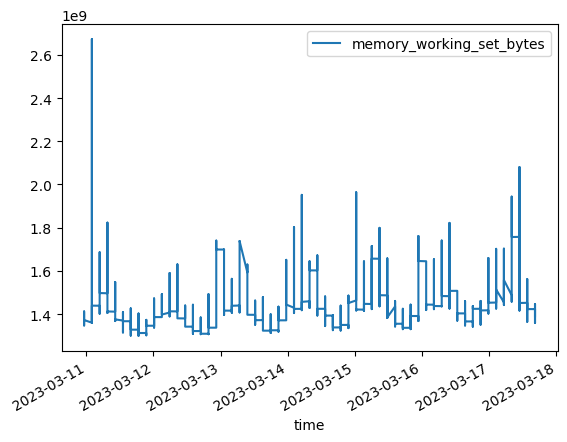

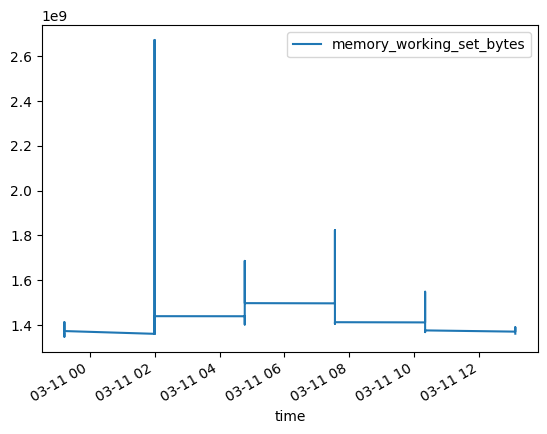

In [16]:
plot_cols = ['memory_working_set_bytes']
plot_features = data[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = data[plot_cols][:1440]
plot_features.index = date_time[:1440]
_ = plot_features.plot(subplots=True)

In [18]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=y_train, test_df=y_test,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [19]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [20]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [21]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.test = test
WindowGenerator.example = example

In [22]:
single_step_window = WindowGenerator(
    input_width=96, label_width=96, shift=1,
    label_columns=['memory_working_set_bytes'])
single_step_window

Total window size: 97
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96]
Label column name(s): ['memory_working_set_bytes']

In [23]:
example_window = tf.stack([np.array(y_train[:single_step_window.total_window_size]),
                           np.array(y_train[200:200+single_step_window.total_window_size]),
                           np.array(y_train[400:400+single_step_window.total_window_size])])

example_inputs, example_labels = single_step_window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 97, 1)
Inputs shape: (3, 96, 1)
Labels shape: (3, 96, 1)


In [24]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [25]:
column_indices = {name: i for i, name in enumerate(data.columns)}
baseline = Baseline(label_index=column_indices['memory_working_set_bytes'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

performance = {}
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

2023-04-06 19:05:38.598681: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [26]:
inputs, labels = single_step_window.example
train_predict = baseline(inputs)
train_predict.shape

TensorShape([32, 96, 1])

In [27]:
plot_col_index = single_step_window.column_indices['memory_working_set_bytes']
plot_col_index

0

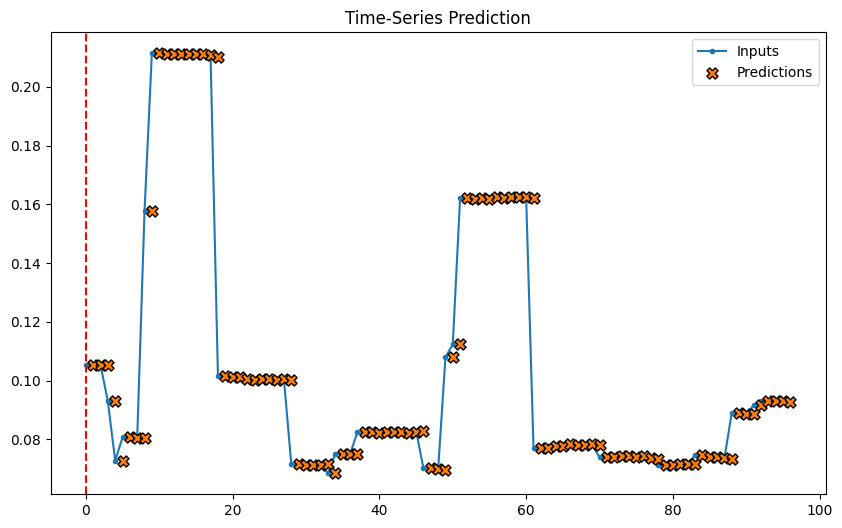

In [29]:

plt.figure(figsize=(10,6)) 
plt.axvline(c='r', linestyle='--') 
plt.plot(single_step_window.input_indices, inputs[0, :, plot_col_index],
            label='Inputs', marker='.', zorder=-10)
plt.scatter(single_step_window.label_indices, train_predict[0, :, single_step_window.label_columns_indices.get('memory_working_set_bytes', None)],
            marker='X', edgecolors='k', label='Predictions',
            c='#ff7f0e', s=64)

plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [30]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False, activation="relu"),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [31]:
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint

MAX_EPOCHS = 1000

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=2,
                                                mode='min')

lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint_v3.h5')
checkpoint = ModelCheckpoint(filename, monitor='loss', verbose=1, save_best_only=True, mode='auto')
history = lstm_model.fit(X_train_tensors_f, y_train, epochs=MAX_EPOCHS,
                    callbacks=[early_stopping, checkpoint])


Epoch 1/1000
469/469 [==============================] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.0164
Epoch 1: loss improved from inf to 0.00112, saving model to model/tmp_checkpoint_v3.h5
469/469 [==============================] - 3s 3ms/step - loss: 0.0011 - mean_absolute_error: 0.0164
Epoch 2/1000
462/469 [============================>.] - ETA: 0s - loss: 4.7491e-04 - mean_absolute_error: 0.0098
Epoch 2: loss improved from 0.00112 to 0.00047, saving model to model/tmp_checkpoint_v3.h5
469/469 [==============================] - 2s 3ms/step - loss: 4.7058e-04 - mean_absolute_error: 0.0097
Epoch 3/1000
464/469 [============================>.] - ETA: 0s - loss: 3.8886e-04 - mean_absolute_error: 0.0085
Epoch 3: loss improved from 0.00047 to 0.00039, saving model to model/tmp_checkpoint_v3.h5
469/469 [==============================] - 2s 3ms/step - loss: 3.8972e-04 - mean_absolute_error: 0.0085
Epoch 4/1000
463/469 [============================>.] - ETA: 0s - loss: 3.7773e-04 - mea

In [32]:
performance['lstm_model'] = lstm_model.evaluate(X_test_tensors_f, y_test, verbose=0)

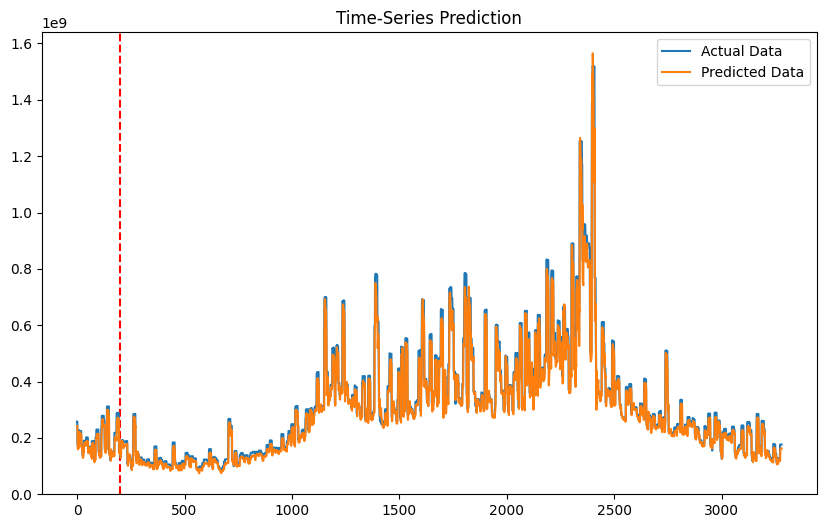

In [34]:
train_predict = lstm_model(X_test_tensors_f)
predicted = train_predict
label_y = y_test

predicted= predicted * MAX
label_y = label_y * MAX
plt.figure(figsize=(10,6)) 
plt.axvline(x=200, c='r', linestyle='--') 

plt.plot(label_y, label='Actual Data') 
plt.plot(predicted, label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [35]:
gru_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [36]:
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint
MAX_EPOCHS = 1000

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=2,
                                                mode='min')

gru_model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint_v3.h5')
checkpoint = ModelCheckpoint(filename, monitor='loss', verbose=1, save_best_only=True, mode='auto')
history = gru_model.fit(X_train_tensors_f, y_train, epochs=MAX_EPOCHS,
                    callbacks=[early_stopping, checkpoint])

Epoch 1/1000
457/469 [============================>.] - ETA: 0s - loss: 8.7199e-04 - mean_absolute_error: 0.0143
Epoch 1: loss improved from inf to 0.00085, saving model to model/tmp_checkpoint_v3.h5
469/469 [==============================] - 4s 4ms/step - loss: 8.5433e-04 - mean_absolute_error: 0.0141
Epoch 2/1000
462/469 [============================>.] - ETA: 0s - loss: 4.3379e-04 - mean_absolute_error: 0.0089
Epoch 2: loss improved from 0.00085 to 0.00043, saving model to model/tmp_checkpoint_v3.h5
469/469 [==============================] - 2s 4ms/step - loss: 4.3177e-04 - mean_absolute_error: 0.0089
Epoch 3/1000
460/469 [============================>.] - ETA: 0s - loss: 3.8152e-04 - mean_absolute_error: 0.0080
Epoch 3: loss improved from 0.00043 to 0.00038, saving model to model/tmp_checkpoint_v3.h5
469/469 [==============================] - 2s 4ms/step - loss: 3.7805e-04 - mean_absolute_error: 0.0080
Epoch 4/1000
458/469 [============================>.] - ETA: 0s - loss: 3.6480e-

In [37]:
performance['gru_model'] = gru_model.evaluate(X_test_tensors_f, y_test, verbose=0)

In [38]:
train_predict = gru_model(X_test_tensors_f)
train_predict.shape

TensorShape([3280, 1])

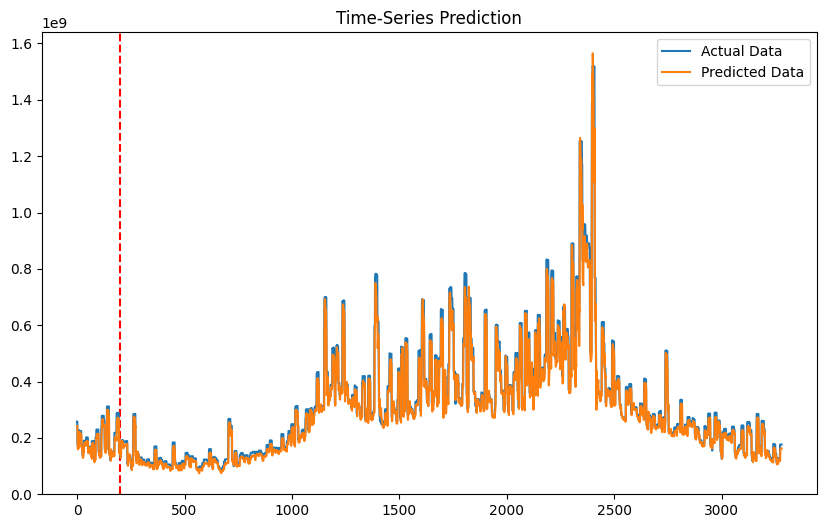

In [39]:
train_predict = lstm_model(X_test_tensors_f)
predicted = train_predict
label_y = y_test

predicted= predicted * MAX
label_y = label_y * MAX
plt.figure(figsize=(10,6)) 
plt.axvline(x=200, c='r', linestyle='--') 

plt.plot(label_y, label='Actual Data') 
plt.plot(predicted, label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [59]:
biLSTM1_model = tf.keras.models.Sequential()
biLSTM1_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))
biLSTM1_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
biLSTM1_model.add(tf.keras.layers.Dense(5))
# biLSTM1_model.add(tf.keras.layers.Activation('softmax'))

In [60]:
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint
MAX_EPOCHS = 1000

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=10,
                                                mode='min')

biLSTM1_model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint_v3.h5')
checkpoint = ModelCheckpoint(filename, monitor='loss', verbose=1, save_best_only=True, mode='auto')
history = biLSTM1_model.fit(X_train_tensors_f, y_train, epochs=MAX_EPOCHS,
                    callbacks=[early_stopping, checkpoint])

Epoch 1/1000
442/469 [===========================>..] - ETA: 0s - loss: 0.0014 - mean_absolute_error: 0.0188
Epoch 1: loss improved from inf to 0.00137, saving model to model/tmp_checkpoint_v3.h5
469/469 [==============================] - 3s 1ms/step - loss: 0.0014 - mean_absolute_error: 0.0183
Epoch 2/1000
469/469 [==============================] - ETA: 0s - loss: 4.4143e-04 - mean_absolute_error: 0.0091
Epoch 2: loss improved from 0.00137 to 0.00044, saving model to model/tmp_checkpoint_v3.h5
469/469 [==============================] - 1s 1ms/step - loss: 4.4143e-04 - mean_absolute_error: 0.0091
Epoch 3/1000
446/469 [===========================>..] - ETA: 0s - loss: 3.9781e-04 - mean_absolute_error: 0.0085
Epoch 3: loss improved from 0.00044 to 0.00039, saving model to model/tmp_checkpoint_v3.h5
469/469 [==============================] - 1s 2ms/step - loss: 3.8692e-04 - mean_absolute_error: 0.0084
Epoch 4/1000
468/469 [============================>.] - ETA: 0s - loss: 3.6719e-04 - mea

In [61]:
train_predict = biLSTM1_model(X_test_tensors_f)
train_predict.shape
train_predict

<tf.Tensor: shape=(3280, 5), dtype=float32, numpy=
array([[0.0952504 , 0.0951952 , 0.09536892, 0.09520082, 0.09508444],
       [0.09436144, 0.09429988, 0.09444958, 0.09430815, 0.094182  ],
       [0.08485381, 0.08481869, 0.0849817 , 0.08494454, 0.08476374],
       ...,
       [0.06332633, 0.06333696, 0.06337257, 0.0633361 , 0.06323139],
       [0.06377001, 0.06378146, 0.06388035, 0.06377225, 0.06368763],
       [0.06421255, 0.06421626, 0.06429958, 0.06419944, 0.06411305]],
      dtype=float32)>

In [62]:
y_test

,memory_working_set_bytes
0,0.096575
1,0.096483
2,0.067065
3,0.063960
4,0.063936
...,...
3275,0.066024
3276,0.066039
3277,0.066039
3278,0.066042


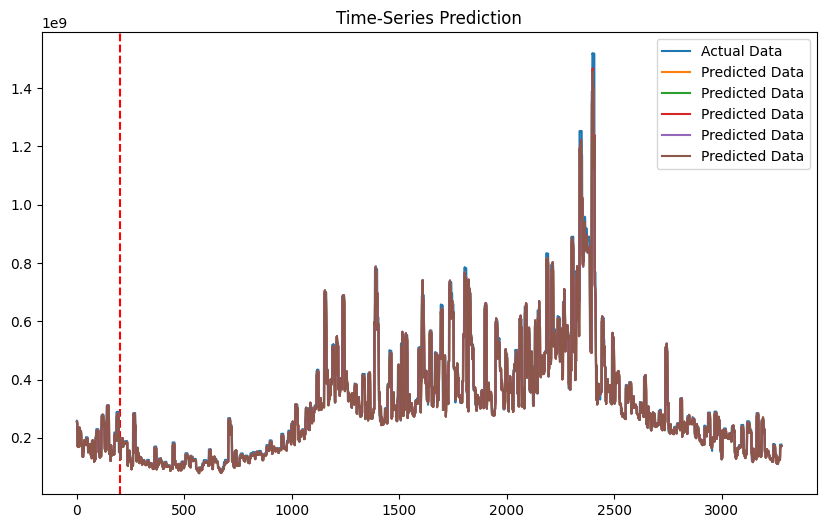

In [65]:
train_predict = biLSTM1_model(X_test_tensors_f)
predicted = train_predict
label_y = y_test

predicted= predicted * MAX
label_y = label_y * MAX
plt.figure(figsize=(10,6)) 
plt.axvline(x=200, c='r', linestyle='--') 
plt.plot(label_y, label='Actual Data') 
plt.plot(predicted, label='Predicted Data') 


plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [66]:
performance['biLSTM1_model'] = biLSTM1_model.evaluate(X_test_tensors_f, y_test, verbose=0)

In [84]:
# With custom backward layer
biLSTM2_model = tf.keras.models.Sequential()
forward_layer = tf.keras.layers.LSTM(32, return_sequences=True)
backward_layer = tf.keras.layers.LSTM(32, activation='relu', return_sequences=True,
                      go_backwards=True)
biLSTM2_model.add(tf.keras.layers.Bidirectional(forward_layer, backward_layer=backward_layer))
biLSTM2_model.add(tf.keras.layers.Dense(5))
biLSTM2_model.add(tf.keras.layers.Activation('softmax'))

In [85]:
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint
MAX_EPOCHS = 1000

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=10,
                                                mode='min')

biLSTM2_model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint_v3.h5')
checkpoint = ModelCheckpoint(filename, monitor='loss', verbose=1, save_best_only=True, mode='auto')
history = biLSTM2_model.fit(X_train_tensors_f, y_train, epochs=MAX_EPOCHS,
                    callbacks=[early_stopping, checkpoint])

Epoch 1/1000
437/469 [==========================>...] - ETA: 0s - loss: 0.0169 - mean_absolute_error: 0.1201
Epoch 1: loss improved from inf to 0.01693, saving model to model/tmp_checkpoint_v3.h5
469/469 [==============================] - 2s 1ms/step - loss: 0.0169 - mean_absolute_error: 0.1201
Epoch 2/1000
458/469 [============================>.] - ETA: 0s - loss: 0.0169 - mean_absolute_error: 0.1201
Epoch 2: loss improved from 0.01693 to 0.01693, saving model to model/tmp_checkpoint_v3.h5
469/469 [==============================] - 0s 1ms/step - loss: 0.0169 - mean_absolute_error: 0.1202
Epoch 3/1000
453/469 [===========================>..] - ETA: 0s - loss: 0.0170 - mean_absolute_error: 0.1202
Epoch 3: loss improved from 0.01693 to 0.01693, saving model to model/tmp_checkpoint_v3.h5
469/469 [==============================] - 0s 999us/step - loss: 0.0169 - mean_absolute_error: 0.1202
Epoch 4/1000
443/469 [===========================>..] - ETA: 0s - loss: 0.0169 - mean_absolute_error: 

In [86]:
performance['biLSTM2_model'] = biLSTM2_model.evaluate(X_test_tensors_f, y_test, verbose=0)

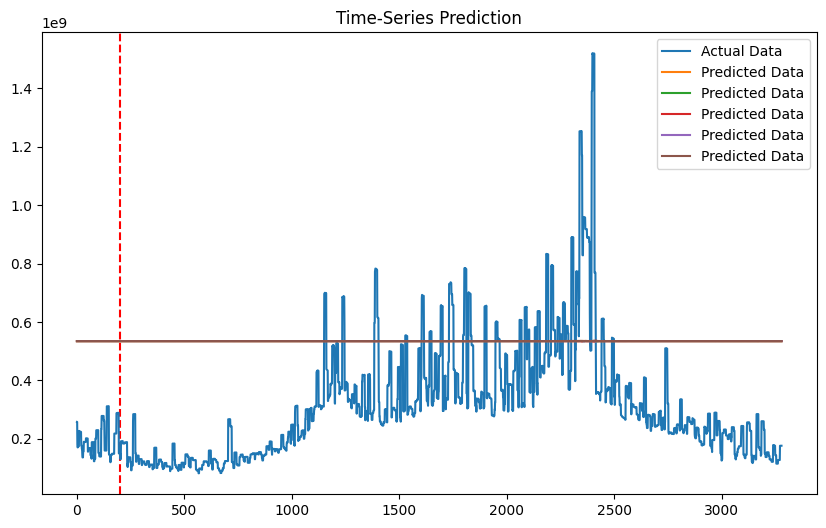

In [87]:
train_predict = biLSTM2_model(X_test_tensors_f)
predicted = train_predict
label_y = y_test

predicted= predicted * MAX
label_y = label_y * MAX
plt.figure(figsize=(10,6)) 
plt.axvline(x=200, c='r', linestyle='--') 
plt.plot(label_y, label='Actual Data') 
plt.plot(predicted[:,0,:], label='Predicted Data') 


plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [70]:
biLSTM3_model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=X_train_tensors_f.shape[-2:]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Dense(128, activation='selu'),
        tf.keras.layers.Dense(1),
    ])

In [162]:
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint
MAX_EPOCHS = 1000

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=10,
                                                mode='min')

biLSTM3_model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint_v3.h5')
checkpoint = ModelCheckpoint(filename, monitor='loss', verbose=1, save_best_only=True, mode='auto')
history = biLSTM3_model.fit(X_train_tensors_f, y_train, epochs=MAX_EPOCHS,
                    callbacks=[early_stopping, checkpoint])

Epoch 1/1000
469/469 [==============================] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.0283
Epoch 1: loss improved from inf to 0.00234, saving model to model/tmp_checkpoint_v3.h5
469/469 [==============================] - 30s 54ms/step - loss: 0.0023 - mean_absolute_error: 0.0283
Epoch 2/1000
468/469 [============================>.] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.0283
Epoch 2: loss improved from 0.00234 to 0.00233, saving model to model/tmp_checkpoint_v3.h5
469/469 [==============================] - 27s 57ms/step - loss: 0.0023 - mean_absolute_error: 0.0283
Epoch 3/1000
469/469 [==============================] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.0284
Epoch 3: loss did not improve from 0.00233
469/469 [==============================] - 25s 54ms/step - loss: 0.0023 - mean_absolute_error: 0.0284
Epoch 4/1000
468/469 [============================>.] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.0283
Epoch 4: loss did not improve from 0.

In [164]:
performance['biLSTM3_model'] = biLSTM3_model.evaluate(X_test_tensors_f, y_test, verbose=0)

In [171]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0794
lstm_model  : 0.0406
gru_model   : 0.0377
biLSTM1_model: 0.0953
biLSTM3_model: 0.0399
biLSTM2_model: 0.0952
